In [1]:
import torch
import torch.utils.data
import cv2
import os
from PIL import Image
from pycocotools.coco import COCO
import torchvision.transforms.functional as F  
import torchvision
from torchvision import datasets, models
from torchvision.transforms import functional as FT
from torchvision import transforms as T
from torch import nn, optim
from torch.utils.data import DataLoader, sampler, random_split, Dataset
from torchvision.models.detection import FasterRCNN_ResNet50_FPN_Weights
from tqdm import tqdm
import math
import copy
import numpy as np # linear algebra
from torchvision.utils import draw_bounding_boxes
import albumentations as A  # our data augmentation library
import matplotlib.pyplot as plt
import warnings
from collections import defaultdict, deque
import datetime
import time
from tqdm import tqdm # progress bar
from torchvision.utils import draw_bounding_boxes
import sys
from torchmetrics.detection.mean_ap import MeanAveragePrecision
from torch.utils.data import Subset
import pandas as pd
from tqdm import tqdm
import random

warnings.filterwarnings("ignore")

In [2]:
"""
Classe Dataset
"""
class MyReducedCocoDataset(torch.utils.data.Dataset):
    def __init__(self, root, annotation_file, transforms=None):
        self.root = root
        self.transforms = transforms
        self.coco = COCO(annotation_file) # Carica le annotazioni
        all_ids = list(sorted(self.coco.imgs.keys())) ##mappo gli id in una lista ordinata
        self.ids=[]

        for img_id in tqdm(all_ids):
            path = self.coco.loadImgs(img_id)[0]['file_name']
            full_path = os.path.join(self.root, path)
            
            if os.path.exists(full_path):
                self.ids.append(img_id)

    def __getitem__(self, index):
        # 1. Carica ID e path immagine
        coco = self.coco
        img_id = self.ids[index] #mi prendo id effettivo immagine
        ann_ids = coco.getAnnIds(imgIds=img_id) #mi prendo le annotations
        coco_annotation = coco.loadAnns(ann_ids)
        
        path = coco.loadImgs(img_id)[0]['file_name']
        
        img = Image.open(os.path.join(self.root, path)).convert("RGB") ##pytorch vuole solo img in rgb

        # 3. Estrai le Box e le Label
        #nbisogna convertire i bounding box
        num_objs = len(coco_annotation)
        boxes = []
        labels = []
        areas = []
        iscrowd = []

        for i in range(num_objs):
            xmin = coco_annotation[i]['bbox'][0]
            ymin = coco_annotation[i]['bbox'][1]
            xmax = xmin + coco_annotation[i]['bbox'][2] # COCO è x,y,w,h -> convertiamo in x,y,x,y
            ymax = ymin + coco_annotation[i]['bbox'][3]
            
            boxes.append([xmin, ymin, xmax, ymax])
            labels.append(coco_annotation[i]['category_id'])
            areas.append(coco_annotation[i]['area'])
            iscrowd.append(coco_annotation[i]['iscrowd'])

        # Conversione in Tensori
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        image_id = torch.tensor([img_id])
        area = torch.as_tensor(areas, dtype=torch.float32)
        iscrowd = torch.as_tensor(iscrowd, dtype=torch.int64)

        # Gestione casi senza box (immagini vuote)
        if num_objs == 0:
            boxes = torch.zeros((0, 4), dtype=torch.float32)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        if not isinstance(img, torch.Tensor):
            img = F.to_tensor(img)
    
        return img, target

    def __len__(self):
        return len(self.ids)

def collate_fn(batch):
    #((img1,target1),(img2,target2)) ---- ((img1,img2),(target1,target2))
    return tuple(zip(*batch))

In [3]:
"""
Creiamo le istanze della classe dataset
e le diamo in input alla classe dataload
"""
IMG_DIR_TRAIN = '/kaggle/input/cococustom/kaggle/working/train'
ANN_FILE_TRAIN = '/kaggle/input/cococustom/kaggle/working/instances_train2017.json'

IMG_DIR_VAL = '/kaggle/input/cococustom/kaggle/working/val'
ANN_FILE_VAL = '/kaggle/input/cococustom/kaggle/working/instances_val2017.json'

dataset_train = MyReducedCocoDataset(root=IMG_DIR_TRAIN, annotation_file=ANN_FILE_TRAIN)
data_loader_train = torch.utils.data.DataLoader(
        dataset_train, 
        batch_size=4, 
        shuffle=True,
        num_workers=2, 
        collate_fn=collate_fn
)

dataset_val = MyReducedCocoDataset(root=IMG_DIR_VAL, annotation_file=ANN_FILE_VAL)
data_loader_val = torch.utils.data.DataLoader(
        dataset_val, 
        batch_size=4, 
        shuffle=True, 
        num_workers=2,
        collate_fn=collate_fn
    )

loading annotations into memory...
Done (t=20.37s)
creating index...
index created!


100%|██████████| 118287/118287 [01:22<00:00, 1439.97it/s]


loading annotations into memory...
Done (t=0.62s)
creating index...
index created!


100%|██████████| 5000/5000 [00:03<00:00, 1521.67it/s]


In [4]:
"""RIDUZIONE DATASETS PER TEST"""
# 1. Definisci quanto grande vuoi che sia il tuo mini-set (es. 50 immagini)
mini_size = 50

# 2. Crea una lista di indici (da 0 a 49)
# Puoi anche usare indici random se preferisci un campione casuale
indices = list(range(mini_size))

# 3. Crea il Subset
mini_dataset_train = Subset(dataset_train, indices)

# 4. Crea il DataLoader specifico per il mini dataset
mini_loader_train = torch.utils.data.DataLoader(
    mini_dataset_train, 
    batch_size=4,           # Stesso batch size o diverso, come preferisci
    shuffle=True,           # Shuffle è utile anche nel test per verificare che il modello non crashi
    num_workers=2, 
    collate_fn=collate_fn   # Importante: mantieni la tua collate_fn
)

print(f"Dimensione dataset TRAIN originale: {len(dataset_train)}")
print(f"Dimensione mini TRAIN dataset: {len(mini_dataset_train)}")

mini_dataset_val = Subset(dataset_val, indices)

# 4. Crea il DataLoader specifico per il mini dataset
mini_loader_val = torch.utils.data.DataLoader(
    mini_dataset_val, 
    batch_size=4,           # Stesso batch size o diverso, come preferisci
    shuffle=True,           # Shuffle è utile anche nel test per verificare che il modello non crashi
    num_workers=2, 
    collate_fn=collate_fn   # Importante: mantieni la tua collate_fn
)

print(f"Dimensione dataset VAL originale: {len(dataset_train)}")
print(f"Dimensione mini VAL dataset: {len(mini_dataset_train)}")


Dimensione dataset TRAIN originale: 11829
Dimensione mini TRAIN dataset: 50
Dimensione dataset VAL originale: 11829
Dimensione mini VAL dataset: 50


In [19]:
"""
Importiamo il modello Faster RCNN ci torchvision
"""
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights='COCO_V1')

"""
Attivare la GPU
"""
device = torch.device("cuda")
model = model.to(device)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:00<00:00, 212MB/s] 


In [7]:
def train_smart(model, optimizer, train_loader, val_loader, device, num_epochs, save_path='.'):
    """
    Funzione di training adattata per Object Detection con struttura avanzata:
    - Training Loop
    - Validation Loop
    - Model Checkpointing (Best & Last)
    - History return
    """
    
    # Setup history e variabili
    history = {
        'train_loss': [],
        'val_loss': [],
        'train_sub_losses': [], # Per salvare classifier, box_reg, etc.
        'val_sub_losses': []
    }
    
    min_val_loss = np.inf
    model.to(device)
    
    fit_time = time.time()
    
    print(f"Inizio training su {device} per {num_epochs} epoche...")

    for epoch in range(num_epochs):
        since = time.time()
        
        # --- TRAINING PHASE ---
        model.train()
        running_loss = 0.0
        running_sub_losses = {} # Per accumulare le loss parziali (rpn, box, class, etc)
        
        # Nota: Se vuoi usare tqdm, avvolgi train_loader qui: tqdm(train_loader)
        for i, (images, targets) in enumerate(train_loader):
            
            # Preparazione dati specifica per Object Detection
            images = list(image.to(device) for image in images)
            targets = [{k: torch.tensor(v).to(device) for k, v in t.items()} for t in targets]

            # Zero grad
            optimizer.zero_grad()

            # Forward pass (Il modello calcola la loss internamente se passiamo i targets)
            loss_dict = model(images, targets)
            
            # Calcolo loss totale
            losses = sum(loss for loss in loss_dict.values())
            loss_value = losses.item()

            # Controllo stabilità
            if not math.isfinite(loss_value):
                print(f"\nLoss is {loss_value}, stopping training")
                print(loss_dict)
                sys.exit(1)

            # Backward & Step
            losses.backward()
            optimizer.step()

            # Accumulo metriche
            running_loss += loss_value
            
            # Accumulo sotto-loss per statistiche (staccandole dal grafo)
            for k, v in loss_dict.items():
                if k not in running_sub_losses:
                    running_sub_losses[k] = 0.0
                running_sub_losses[k] += v.item()

        # Media epocale train
        epoch_train_loss = running_loss / len(train_loader)
        epoch_train_sub = {k: v / len(train_loader) for k, v in running_sub_losses.items()}

        # --- VALIDATION PHASE ---
        # ATTENZIONE: Per i modelli di Detection Torchvision, se metti model.eval(),
        # il modello restituisce predizioni (box), NON loss. 
        # Per monitorare la val_loss, rimaniamo in .train() ma con torch.no_grad().
        running_val_loss = 0.0
        running_val_sub_losses = {}
        
        with torch.no_grad():
            # model.train() # Rimane tecnicamente in train mode per calcolare le loss
            for images, targets in val_loader:
                images = list(image.to(device) for image in images)
                targets = [{k: torch.tensor(v).to(device) for k, v in t.items()} for t in targets]

                loss_dict = model(images, targets)
                losses = sum(loss for loss in loss_dict.values())
                
                running_val_loss += losses.item()
                
                for k, v in loss_dict.items():
                    if k not in running_val_sub_losses:
                        running_val_sub_losses[k] = 0.0
                    running_val_sub_losses[k] += v.item()

        # Media epocale val
        epoch_val_loss = running_val_loss / len(val_loader)
        epoch_val_sub = {k: v / len(val_loader) for k, v in running_val_sub_losses.items()}

        # --- SALVATAGGIO STORICO ---
        history['train_loss'].append(epoch_train_loss)
        history['val_loss'].append(epoch_val_loss)
        history['train_sub_losses'].append(epoch_train_sub)
        history['val_sub_losses'].append(epoch_val_sub)

        # --- CHECKPOINTING (Best Model) ---
        if epoch_val_loss < min_val_loss:
            print('Loss Decreasing.. {:.4f} >> {:.4f} (Saving Model)'.format(min_val_loss, epoch_val_loss))
            min_val_loss = epoch_val_loss
            torch.save(model, f'{save_path}/model_best.pt')

        # --- STAMPA STATISTICHE ---
        time_elapsed = time.time() - since
        print("Epoch:{}/{} | Time: {:.0f}m {:.0f}s".format(epoch + 1, num_epochs, time_elapsed // 60, time_elapsed % 60))
        print(f"Train Loss: {epoch_train_loss:.5f} | Val Loss: {epoch_val_loss:.5f}")
        # Stampa opzionale di una componente specifica (es. classifier loss)
        # print(f"Train Class Loss: {epoch_train_sub.get('loss_classifier', 0):.5f}") 
        print("-" * 60)

    # --- FINE TRAINING ---
    total_time = time.time() - fit_time
    print('Total training time: {:.0f}m {:.0f}s'.format(total_time // 60, total_time % 60))
    print('Saving last model...')
    torch.save(model, f'{save_path}/model_last.pt')
    
    return history

In [8]:
# --- ESEMPIO DI UTILIZZO ---
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

In [ ]:
# Assicurati di avere un data_loader_val definito
history = train_smart(
    model=model, 
    optimizer=optimizer, 
    train_loader=data_loader_train, 
    val_loader=data_loader_val,  # Serve un validation loader
    device=device, 
    num_epochs=10
)

In [ ]:
# Crea una nuova figura
plt.figure(figsize=(10, 5)) # Opzionale: rende il grafico un po' più largo

# Plot delle curve
plt.plot(history['train_loss'], color='blue', label='Train Loss')
plt.plot(history['val_loss'], color='red', label='Validation Loss')

# Configurazioni
plt.legend(loc='upper right')
plt.xlabel('Epochs')
plt.ylabel('Total Loss') # Corretto per Object Detection
plt.title('Training vs Validation Loss')
plt.grid(True, linestyle='--', alpha=0.6) # Opzionale: aggiunge una griglia per leggibilità

plt.show()

In [9]:
def compute_iou(box1, box2):
    """
    Calcola l’IoU tra due bounding box.
    box formato: [x_min, y_min, x_max, y_max]
    """
    xA = max(box1[0], box2[0])
    yA = max(box1[1], box2[1])
    xB = min(box1[2], box2[2])
    yB = min(box1[3], box2[3])

    inter_w = max(0, xB - xA)
    inter_h = max(0, yB - yA)
    interArea = inter_w * inter_h

    box1Area = (box1[2] - box1[0]) * (box1[3] - box1[1])
    box2Area = (box2[2] - box2[0]) * (box2[3] - box2[1])

    iou = interArea / float(box1Area + box2Area - interArea + 1e-6)
    return iou

In [10]:
# sovrapposizione totale
boxA = [10, 10, 50, 50]
boxB = [10, 10, 50, 50]
print("IoU:", compute_iou(boxA, boxB))

# sovrapposizione parziale
boxA = [10, 10, 50, 50]
boxB = [30, 30, 70, 70]
print("IoU:", compute_iou(boxA, boxB))

# sovrapposizione assente
boxA = [10, 10, 40, 40]
boxB = [50, 50, 80, 80]
print("IoU:", compute_iou(boxA, boxB))

IoU: 0.999999999375
IoU: 0.14285714280612247
IoU: 0.0


In [22]:
"""
Precision=TP/TP+FP
Recall=TP/TP+FN

Condizioni:
1. Ha trovato l’oggetto nel punto giusto? Confronta ogni box predetto con quello reale usando la IoU
2. Ha riconosciuto la classe giusta? Verifica che la label sia la stessa del Ground Truth
Se entrambi sono veri: True Positive (TP)
Se una delle due condizioni non è soddisfatta: False Positive (FP)
Se un oggetto reale non viene mai trovato: False Negative (FN)

NON è sufficiente per mAP
per la quale serve fare Precision e Recall per ogni classe e per più soglie
"""
def compute_precision_recall_fasterrcnn(predictions, targets, iou_threshold=0.5):
    tp = 0
    fp = 0
    fn = 0

    for pred, gt in zip(predictions, targets):

        pred_boxes = pred["boxes"].cpu().numpy()
        pred_labels = pred["labels"].cpu().numpy()
        pred_scores = pred["scores"].cpu().numpy()

        gt_boxes = gt["boxes"].cpu().numpy()
        gt_labels = gt["labels"].cpu().numpy()

        matched_gt = set()

        # Ordina predizioni per score decrescente
        sorted_indices = np.argsort(-pred_scores)
        pred_boxes = pred_boxes[sorted_indices]
        pred_labels = pred_labels[sorted_indices]
        pred_scores = pred_scores[sorted_indices]  # ⬅️ questa riga è fondamentale
        
        # Filtra predizioni con confidence troppo bassa
        score_threshold = 0.05
        valid = pred_scores >= score_threshold
        pred_boxes = pred_boxes[valid]
        pred_labels = pred_labels[valid]
        pred_scores = pred_scores[valid]


        for pb, pl in zip(pred_boxes, pred_labels):

            best_iou = 0
            best_gt = -1

            for i, (gt_b, gt_l) in enumerate(zip(gt_boxes, gt_labels)):
                
                if i in matched_gt:
                    continue  # già assegnato a un TP
                
                if pl != gt_l:
                    continue  # classe sbagliata

                iou = compute_iou(pb, gt_b)
                if iou > best_iou:
                    best_iou = iou
                    best_gt = i

            if best_iou >= iou_threshold and best_gt not in matched_gt:
                tp += 1
                matched_gt.add(best_gt)
            else:
                fp += 1
        
        fn += len(gt_boxes) - len(matched_gt)

    precision = tp / (tp + fp + 1e-6)
    recall = tp / (tp + fn + 1e-6)

    return precision, recall

In [23]:
predictions = [{
    "boxes": torch.tensor([
        [12, 12, 48, 48],   # match buono con la persona
        [55, 55, 95, 95],   # box giusto sul cane, ma classe sbagliata
        [0, 0, 20, 20],     # predizione su sfondo
    ], dtype=torch.float32),
    "labels": torch.tensor([
        1,  # persona → CORRETTO
        3,  # gatto → SBAGLIATO
        1,  # persona → SBAGLIATO → FP
    ]),
    "scores": torch.tensor([
        0.98, # molto alto
        0.90,
        0.30,
    ])
}]

targets = [{
    "boxes": torch.tensor([
        [10, 10, 50, 50],   # persona
        [60, 60, 100, 100], # cane
    ], dtype=torch.float32),
    "labels": torch.tensor([
        1,  # classe persona
        2,  # classe cane
    ])
}]

precision, recall = compute_precision_recall_fasterrcnn(predictions, targets)
print("Precision:", precision)
print("Recall:", recall)

Precision: 0.33333322222225925
Recall: 0.499999750000125


In [13]:
"""
Cosa misura la mAP?
Misura quanto bene un modello:
1. trova tutti gli oggetti corretti (completezza -> recall)
2. evita falsi positivi (precisione -> precision)
Come si ottiene la mAP?
1. Per ogni classe si costruisce la Precision-Recall curve
2. Si calcola l’Average Precision (AP) = area sotto quella curva
3. Si calcola la media delle AP di tutte le classi -> Mean AP

La curva di colcola al variare della soglia
Che cos’è la “soglia”?
Ogni predizione del detector ha un valore di confidence score
(es: “sono 95% sicuro che questo è un cane”)
Se scegli una soglia (es. 0.7) allora:
Se lo score ≥ 0.7 -> accetto la predizione
Se lo score < 0.7 -> la scarto
Variando questa soglia ottieni situazioni diverse:
Soglia	    Predizioni	            Precision	Recall
Alta (0.9)	poche ma sicure	        ↑ alta	    ↓ bassa
Bassa (0.3)	tante, anche sbagliate	↓ bassa	    ↑ alta
Ogni soglia produce un punto diverso nella curva Precision–Recall

Nota: la mAP è in funzione anche della soglia della IoU
fissata lei, si calcola il valore di mAP
"""
def evaluate_map_from_data(predictions, targets, device="cuda"):
    metric = MeanAveragePrecision(box_format="xyxy", class_metrics=True)

    if device == "cuda" and not torch.cuda.is_available():
        device = "cpu"

    formatted_preds = []
    formatted_targets = []

    for pred in predictions:
        formatted_preds.append({
            "boxes": pred["boxes"].to(device),
            "scores": pred["scores"].to(device),
            "labels": pred["labels"].to(device),
        })

    for tgt in targets:
        formatted_targets.append({
            "boxes": tgt["boxes"].to(device),
            "labels": tgt["labels"].to(device),
        })

    metric.update(formatted_preds, formatted_targets)
    results = metric.compute()

    print("AP Per Classe:")
    for i, ap in enumerate(results["map_per_class"]):
        print(f"  Classe {i}: {float(ap):.4f}")

    print("RISULTATI mAP")
    print(f"mAP IoU=0.50:0.95: {results['map']:.4f}")
    print(f"mAP IoU=0.50:      {results['map_50']:.4f}")
    print(f"mAP IoU=0.75:      {results['map_75']:.4f}")

    return results

In [14]:
targets = [
    {"boxes": torch.tensor([[10.,10.,60.,110.],[120.,40.,200.,160.]]), "labels": torch.tensor([0,1])},
    {"boxes": torch.tensor([[15.,18.,65.,120.],[230.,60.,350.,200.]]), "labels": torch.tensor([0,2])},
    {"boxes": torch.tensor([[50.,40.,120.,160.]]), "labels": torch.tensor([0])},
    {"boxes": torch.tensor([[100.,30.,180.,140.],[20.,40.,80.,100.]]), "labels": torch.tensor([1,0])},
    {"boxes": torch.tensor([[250.,80.,400.,250.]]), "labels": torch.tensor([2])}
]

predictions = [
    {"boxes": torch.tensor([[12.,12.,58.,108.],[118.,42.,198.,158.],[200.,200.,260.,260.]]),
     "scores": torch.tensor([0.97,0.88,0.12]), "labels": torch.tensor([0,1,1])},
    {"boxes": torch.tensor([[16.,20.,60.,115.],[220.,55.,340.,205.],[250.,50.,300.,100.]]),
     "scores": torch.tensor([0.91,0.86,0.40]), "labels": torch.tensor([0,2,1])},
    {"boxes": torch.tensor([[45.,35.,118.,162.],[200.,200.,260.,260.]]),
     "scores": torch.tensor([0.95,0.22]), "labels": torch.tensor([0,2])},
    {"boxes": torch.tensor([[22.,38.,82.,102.],[90.,20.,175.,135.],[0.,0.,30.,30.]]),
     "scores": torch.tensor([0.87,0.92,0.10]), "labels": torch.tensor([0,1,0])},
    {"boxes": torch.tensor([[250.,82.,395.,248.],[90.,90.,150.,150.]]),
     "scores": torch.tensor([0.90,0.20]), "labels": torch.tensor([2,0])}
]

results = evaluate_map_from_data(predictions, targets, device="cpu")

AP Per Classe:
  Classe 0: 0.7691
  Classe 1: 0.6010
  Classe 2: 0.7515
RISULTATI mAP
mAP IoU=0.50:0.95: 0.7072
mAP IoU=0.50:      1.0000
mAP IoU=0.75:      0.7508


In [ ]:
"""
Babysitting with randsearch DANILO
"""
# ==========================================
# 1. FUNZIONE DI TRAINING (Invariata)
# ==========================================
def train_one_epoch(model, optimizer, loader, device, epoch):
    model.to(device)
    model.train()
    
    all_losses = []
    
    # Barra di progresso per l'epoca
    pbar = tqdm(loader, desc=f"   Epoch {epoch}", leave=False)
    
    for images, targets in pbar:
        images = list(image.to(device) for image in images)
        targets = [{k: torch.tensor(v).to(device) for k, v in t.items()} for t in targets]
        
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        loss_value = losses.item()
        
        if not math.isfinite(loss_value):
            return float('inf')
        
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
        
        all_losses.append(loss_value)
        pbar.set_description(f"   Loss: {loss_value:.4f}")

    return np.mean(all_losses)

# ==========================================
# 2. RANDOM SEARCH (LR + MOMENTUM)
# ==========================================
def run_random_search_tuning(start_model, train_loader, device, num_trials=10, epochs_per_trial=10):
    print(f"--- Inizio Random Search (LR + Momentum) ---")
    print(f"Trials: {num_trials} | Epochs per Trial: {epochs_per_trial}")
    
    # Salviamo i pesi iniziali per il reset
    initial_weights = copy.deepcopy(start_model.state_dict())
    
    best_config = None
    best_loss = float('inf')
    results = []

    for trial in range(num_trials):
        # --- A. Generazione Parametri Casuali ---
        
        # 1. Learning Rate (Scala Logaritmica tra 1e-5 e 1e-1)
        lr_exponent = np.random.uniform(-5, -1) 
        current_lr = 10 ** lr_exponent
        
        # 2. Momentum (Scala Lineare tra 0.8 e 0.99)
        # Il momentum è solitamente alto, valori sotto 0.8 sono rari per SGD in visione
        current_momentum = np.random.uniform(0.9, 0.99)
        
        print(f"\n=== TRIAL {trial+1}/{num_trials} | LR: {current_lr:.6f} | Momentum: {current_momentum:.4f} ===")
        
        # --- B. Reset Modello ---
        model = copy.deepcopy(start_model)
        model.load_state_dict(initial_weights)
        model.to(device)
        
        # --- C. Optimizer con i parametri random ---
        params = [p for p in model.parameters() if p.requires_grad]
        optimizer = torch.optim.SGD(
            params, 
            lr=current_lr, 
            momentum=current_momentum, # <-- Parametro dinamico
            weight_decay=0.0005
        )
        
        # --- D. Training Loop ---
        final_loss = float('inf')
        trial_failed = False
        
        for epoch in range(epochs_per_trial):
            avg_loss = train_one_epoch(model, optimizer, train_loader, device, epoch)
            
            if avg_loss == float('inf'):
                print(f"   -> Trial Fallito (Loss esplosa).")
                trial_failed = True
                final_loss = float('inf')
                break
            
            final_loss = avg_loss
        
        if not trial_failed:
            print(f"   -> Risultato: Loss Finale = {final_loss:.6f}")
        
        # Salvataggio dati
        results.append({
            'lr': current_lr, 
            'momentum': current_momentum, 
            'loss': final_loss
        })
        
        # Aggiornamento Best
        if final_loss < best_loss:
            best_loss = final_loss
            best_config = {'lr': current_lr, 'momentum': current_momentum}
            print(f"   >>> NUOVO RECORD! (LR={current_lr:.6f}, Mom={current_momentum:.4f})")

    # --- FINE ---
    print("\n========================================")
    print("--- CLASSIFICA FINALE (Top 3) ---")
    
    # Ordiniamo per loss (dal più basso al più alto)
    results.sort(key=lambda x: x['loss'])
    
    for i, res in enumerate(results[:3]):
        print(f"{i+1}. Loss: {res['loss']:.6f} | LR: {res['lr']:.6f} | Mom: {res['momentum']:.4f}")
        
    print(f"\nPARAMETRI VINCITORI DA USARE:")
    print(f"Optimizer: SGD")
    print(f"LR:       {best_config['lr']:.6f}")
    print(f"Momentum: {best_config['momentum']:.4f}")
    
    return best_config

# ==========================================
# 3. ESECUZIONE
# ==========================================
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
start_model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights=None)

# Assicurati di avere 'mini_loader_train'
if 'mini_loader_train' in locals() or 'mini_loader_train' in globals():
    best_params = run_random_search_tuning(
        start_model, 
        mini_loader_train, 
        device, 
        num_trials=10,       # Numero di tentativi casuali
        epochs_per_trial=10  # Epoche per ogni tentativo
    )
else:
    print("Devi definire 'mini_loader_train' prima di lanciare il codice.")

In [ ]:
"""
Babysitting PAOLO
"""
# ==========================================
# 1. FUNZIONE DI TRAINING (Invariata)
# ==========================================
def train_one_epoch(model, optimizer, loader, device, epoch):
    model.to(device)
    model.train()
    
    all_losses = []
    
    # tqdm con leave=False per non intasare la console durante i 100 step totali
    pbar = tqdm(loader, desc=f"    Epoch {epoch}", leave=False)
    
    for images, targets in pbar:
        # Gestione dei target come nel codice originale
        images = list(image.to(device) for image in images)
        targets = [{k: torch.tensor(v).to(device) for k, v in t.items()} for t in targets]
        
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        loss_value = losses.item()
        
        if not math.isfinite(loss_value):
            print(f"Loss is {loss_value}, stopping training")
            # In caso di nan, ritorniamo infinito per scartare questo Trial
            return float('inf')
        
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
        
        all_losses.append(loss_value)
        pbar.set_description(f"    Loss: {loss_value:.4f}")

    # Restituisce la MEDIA della loss di tutta l'epoca
    return np.mean(all_losses)

# ==========================================
# 2. LOGICA RANDOM SEARCH (Modificata)
# ==========================================
def run_random_search(start_model, train_loader, device, num_trials=10, epochs_per_trial=10):
    print(f"--- Inizio Random Search per (LR, Momentum) ---")
    print(f"Trials: {num_trials} | Epochs per Trial: {epochs_per_trial}")
    
    # PARAMETRI PER IL CAMPIONAMENTO
    # LR: Distribuzione Gaussiana centrata su 0.01 (10^-2) con deviazione standard logaritmica
    LR_MEAN_EXP = -(3.2013)  # Corrisponde a 10^-2 = 0.01 (il tuo LR fissato in precedenza)
    LR_STD_EXP = 1.0    # Deviazione standard sull'esponente logaritmico (es. per esplorare da 10^-3 a 10^-1)
    # Momentum: Distribuzione Uniforme nell'intervallo [0.8, 0.99]
    MOMENTUM_LOW = 0.8
    MOMENTUM_HIGH = 0.99
    
    # 1. Salviamo lo stato iniziale dei pesi per resettare ogni volta
    initial_weights = copy.deepcopy(start_model.state_dict())
    
    best_lr = None
    best_momentum = None
    best_loss = float('inf')
    results = []

    for trial in range(num_trials):
        # A. Generiamo gli iper-parametri casuali
        
        # 1. Campionamento LR (Gaussiano su scala logaritmica)
        # Genera l'esponente logaritmico usando una gaussiana
        lr_exponent = np.random.normal(loc=LR_MEAN_EXP, scale=LR_STD_EXP) 
        current_lr = 10 ** lr_exponent
        
        # Clampa LR nell'intervallo ragionevole [10^-5, 10^-1] per evitare overflow
        if current_lr < 1e-5:
            current_lr = 1e-5
        elif current_lr > 1e-1:
            current_lr = 1e-1
            
        # 2. Campionamento Momentum (Uniforme)
        current_momentum = np.random.uniform(MOMENTUM_LOW, MOMENTUM_HIGH)
        
        print(f"\n=== TRIAL {trial+1}/{num_trials} | Testing LR: {current_lr:.6f} | Momentum: {current_momentum:.4f} ===")
        
        # B. Resettiamo il modello allo stato iniziale
        model = copy.deepcopy(start_model)
        model.load_state_dict(initial_weights)
        model.to(device)
        
        # C. Optimizer SGD (ora include il momentum campionato)
        params = [p for p in model.parameters() if p.requires_grad]
        optimizer = torch.optim.SGD(
            params, 
            lr=current_lr, 
            momentum=current_momentum, # <--- Momentum campionato
            weight_decay=0.0005
        )
        
        # D. Training Loop per questo Trial
        final_loss = float('inf')
        for epoch in range(epochs_per_trial):
            avg_loss = train_one_epoch(model, optimizer, train_loader, device, epoch)
            
            if avg_loss == float('inf'):
                print("    -> Loss esplosa (NaN/Inf). Trial fallito.")
                final_loss = float('inf')
                break
            
            final_loss = avg_loss
            
        print(f"    -> Risultato Trial {trial+1}: Loss Finale = {final_loss:.6f}")
        
        # Salviamo i risultati
        results.append({'lr': current_lr, 'momentum': current_momentum, 'loss': final_loss})
        
        # E. Aggiorniamo il best
        if final_loss < best_loss:
            best_loss = final_loss
            best_lr = current_lr
            best_momentum = current_momentum
            print(f"    >>> NUOVO RECORD! LR {best_lr:.6f}, Momentum {best_momentum:.4f} è il migliore finora.")

    print("\n========================================")
    print("--- FINE RANDOM SEARCH ---")
    print("========================================")
    
    # Ordiniamo i risultati per loss
    results.sort(key=lambda x: x['loss'])
    
    print("\nClassifica Top 3 coppie (LR, Momentum):")
    for i, res in enumerate(results[:3]):
        print(f"{i+1}. LR: {res['lr']:.6f}, Momentum: {res['momentum']:.4f} -> Loss: {res['loss']:.6f}")
        
    print(f"\nIL VINCITORE È: LR = {best_lr:.6f}, Momentum = {best_momentum:.4f}")
    return best_lr, best_momentum

# ==========================================
# 3. ESECUZIONE (Modificata per restituire due valori)
# ==========================================

# Configurazione Device
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"Usando device: {device}")

# Prepara il modello (solo architettura)
# Abbiamo bisogno di più classi se usiamo il dataset COCO ridotto (che ha 80 classi + 1 background)
NUM_CLASSES = 91 # Se stai usando il COCO completo (80 + 1 background) o il COCO ridotto standard. Adatta questo se il tuo dataset ridotto ha un numero di classi diverso.
start_model = torchvision.models.detection.fasterrcnn_resnet50_fpn(
    weights=None, 
    num_classes=NUM_CLASSES # Aggiungo num_classes per chiarezza, anche se weights=None lo farebbe automaticamente.
)

# Assicurati che mini_loader_train sia definito
if 'mini_loader_train' in locals() or 'mini_loader_train' in globals():
    # La funzione ora ritorna la coppia (LR, Momentum)
    best_lr, best_momentum = run_random_search(
        start_model, 
        mini_loader_train, 
        device, 
        num_trials=10,     # Provo 10 coppie diverse
        epochs_per_trial=10 # Addestro per 10 epoche ciascuno
    )
else:
    print("ERRORE: Definisci 'mini_loader_train' prima di eseguire.")

In [15]:
"""
Stessa di sopra ma plotta per ogni batch
"""
def train_smart_realtime(model, optimizer, train_loader, val_loader, device, num_epochs, save_path='.'):
    history = {
        'train_loss': [],
        'val_loss': [],
        'train_sub_losses': [],
        'val_sub_losses': []
    }
    
    min_val_loss = np.inf
    model.to(device)
    
    fit_time = time.time()
    print(f"Inizio training su {device} per {num_epochs} epoche...")

    for epoch in range(num_epochs):
        since = time.time()
        
        # --- TRAINING PHASE ---
        model.train()
        running_loss = 0.0
        running_sub_losses = {}
        
        # 1. Creiamo la barra di progresso (tqdm) sul train_loader
        pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [TRAIN]", leave=False)
        
        # Usiamo pbar invece di train_loader nel ciclo
        for images, targets in pbar:
            
            images = list(image.to(device) for image in images)
            targets = [{k: torch.tensor(v).to(device) for k, v in t.items()} for t in targets]

            optimizer.zero_grad()

            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())
            loss_value = losses.item()

            if not math.isfinite(loss_value):
                print(f"\nLoss is {loss_value}, stopping training")
                sys.exit(1)

            losses.backward()
            optimizer.step()

            # Accumulo metriche
            running_loss += loss_value
            for k, v in loss_dict.items():
                if k not in running_sub_losses:
                    running_sub_losses[k] = 0.0
                running_sub_losses[k] += v.item()
            
            # 2. AGGIORNAMENTO ON-TIME: Mostriamo la loss corrente nella barra
            # 'loss': mostra la loss dell'ultimo batch (istantanea)
            # 'avg': mostra la media accumulata fino ad ora
            current_avg = running_loss / (pbar.n + 1)
            pbar.set_postfix({'batch_loss': loss_value, 'running_avg': current_avg})

        # Media epocale train (calcolata alla fine della barra)
        epoch_train_loss = running_loss / len(train_loader)
        epoch_train_sub = {k: v / len(train_loader) for k, v in running_sub_losses.items()}

        # --- VALIDATION PHASE ---
        running_val_loss = 0.0
        running_val_sub_losses = {}
        
        # 3. Barra di progresso anche per la validazione
        pbar_val = tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [VAL]", leave=False)
        
        with torch.no_grad():
            for images, targets in pbar_val:
                images = list(image.to(device) for image in images)
                targets = [{k: torch.tensor(v).to(device) for k, v in t.items()} for t in targets]

                loss_dict = model(images, targets)
                losses = sum(loss for loss in loss_dict.values())
                
                loss_val_value = losses.item()
                running_val_loss += loss_val_value
                
                for k, v in loss_dict.items():
                    if k not in running_val_sub_losses:
                        running_val_sub_losses[k] = 0.0
                    running_val_sub_losses[k] += v.item()
                
                # Aggiornamento barra validazione
                pbar_val.set_postfix({'val_loss': loss_val_value})

        epoch_val_loss = running_val_loss / len(val_loader)
        epoch_val_sub = {k: v / len(val_loader) for k, v in running_val_sub_losses.items()}

        # --- SALVATAGGIO STORICO ---
        history['train_loss'].append(epoch_train_loss)
        history['val_loss'].append(epoch_val_loss)
        history['train_sub_losses'].append(epoch_train_sub)
        history['val_sub_losses'].append(epoch_val_sub)

        # --- CHECKPOINTING ---
        if epoch_val_loss < min_val_loss:
            # Opzionale: stampa un messaggio quando trovi un nuovo best
            # print(f"  --> New Best found! ({min_val_loss:.4f} -> {epoch_val_loss:.4f})")
            min_val_loss = epoch_val_loss
            torch.save(model, f'{save_path}/model_best.pt')

        # --- STAMPA FINALE EPOCA (Riepilogo pulito) ---
        time_elapsed = time.time() - since
        
        # Stampa pulita che non viene sovrascritta dalla barra
        print(f"Epoch {epoch + 1}/{num_epochs} | Time: {time_elapsed:.0f}s | "
              f"Train Loss: {epoch_train_loss:.4f} | Val Loss: {epoch_val_loss:.4f} "
              f"{'(*BEST*)' if epoch_val_loss == min_val_loss else ''}")

    total_time = time.time() - fit_time
    print('Total training time: {:.0f}m {:.0f}s'.format(total_time // 60, total_time % 60))
    torch.save(model, f'{save_path}/model_last.pt')
    
    return history

In [ ]:
"""
Inizio Train
"""
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights=None)
model.train()

params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.004862, momentum= 0.9497,weight_decay=0.0005)
        
NUM_EPOCHS=5
SAVE_DIR="/kaggle/working/"
# Usa i loader che hai già
loader_t = mini_loader_train
# Se non hai un val loader, usa il train loader anche per validation per ora
loader_v = mini_loader_val
    
# Avvio
history = train_smart_realtime(
        model=model,
        optimizer=optimizer,
        train_loader=loader_t,
        val_loader=loader_v,
        device=device,
        num_epochs=NUM_EPOCHS,
        save_path=SAVE_DIR
    )

In [ ]:
def plot_losses(history):
    """
    Plotta le curve di loss per Train e Validation.
    Gestisce sia la loss totale che le sotto-loss (se presenti).
    """
    
    # 1. Recupero Dati Principali
    train_loss = history.get('train_loss', [])
    val_loss = history.get('val_loss', [])
    epochs = range(1, len(train_loss) + 1)
    
    # --- GRAFICO 1: LOSS TOTALE ---
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, train_loss, 'b-', label='Training Loss', linewidth=2)
    
    if val_loss:
        plt.plot(epochs, val_loss, 'r--', label='Validation Loss', linewidth=2)
        
        # Evidenzia il punto minimo della validation loss
        min_val = min(val_loss)
        min_epoch = val_loss.index(min_val) + 1
        plt.scatter(min_epoch, min_val, s=100, c='green', marker='o', label=f'Best Model (Ep {min_epoch})')
        plt.annotate(f'{min_val:.4f}', (min_epoch, min_val), textcoords="offset points", xytext=(0,10), ha='center', color='green')

    plt.title('Andamento Loss Totale (Faster R-CNN)', fontsize=16)
    plt.xlabel('Epoche', fontsize=12)
    plt.ylabel('Loss', fontsize=12)
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.show()

    # --- GRAFICO 2: SOTTO-LOSS (CLASSIFIER, BOX, RPN...) ---
    # Questo parte solo se la history ha salvato i dettagli (train_sub_losses)
    if 'train_sub_losses' in history and len(history['train_sub_losses']) > 0:
        
        # Recuperiamo le chiavi delle sotto-loss dal primo elemento
        keys = history['train_sub_losses'][0].keys()
        num_plots = len(keys)
        
        # Creiamo una griglia di grafici
        rows = math.ceil(num_plots / 2)
        fig, axes = plt.subplots(rows, 2, figsize=(15, 5 * rows))
        fig.suptitle('Dettaglio Componenti della Loss', fontsize=16)
        axes = axes.flatten()
        
        for i, key in enumerate(keys):
            ax = axes[i]
            
            # Estrai i dati per questa specifica loss (es. loss_classifier)
            sub_train = [h[key] for h in history['train_sub_losses']]
            
            ax.plot(epochs, sub_train, label=f'Train {key}', color='tab:blue')
            
            # Se abbiamo anche i dettagli della validation
            if 'val_sub_losses' in history and len(history['val_sub_losses']) > 0:
                sub_val = [h[key] for h in history['val_sub_losses']]
                ax.plot(epochs, sub_val, label=f'Val {key}', color='tab:orange', linestyle='--')
            
            ax.set_title(key)
            ax.set_xlabel('Epoche')
            ax.set_ylabel('Loss')
            ax.legend()
            ax.grid(True, alpha=0.5)
            
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()

# --- ESEMPIO DI UTILIZZO ---
# Assicurati di aver eseguito il training prima di lanciare questa riga
if 'history' in locals():
    plot_losses(history)
else:
    print("Variabile 'history' non trovata. Esegui prima il training!")

In [33]:
import torch
import numpy as np
import matplotlib.pyplot as plt

def evaluate_detector(model, dataloader, device="cuda", iou_threshold=0.5, visualize=True, vis_score_threshold=0.5):
    model.to(device)
    model.eval()

    all_predictions = []
    all_targets = []

    # variabili per memorizzare l’ultimo batch per la visualizzazione
    last_images = None
    last_predictions = None
    last_targets = None

    with torch.no_grad():
        for images, targets in dataloader:
            images = [img.to(device) for img in images]
            targets = [{k: v.to(device) for k,v in t.items()} for t in targets]

            predictions = model(images)

            # accumulo predizioni e target per le metriche
            all_predictions.extend(predictions)
            all_targets.extend(targets)

            # salvo l’ultimo batch per il plot
            last_images = images
            last_predictions = predictions
            last_targets = targets

    # CALCOLO METRICHE
    precision, recall = compute_precision_recall_fasterrcnn(all_predictions, all_targets, iou_threshold=iou_threshold)
    map_results = evaluate_map_from_data(all_predictions, all_targets, device=device)

    # OUTPUT METRICHE
    print("\n📌 RISULTATI VALIDAZIONE")
    print(f"Precision (IoU ≥ {iou_threshold}): {precision:.4f}")
    print(f"Recall    (IoU ≥ {iou_threshold}): {recall:.4f}")
    print("\n--- mAP ---")
    print(f"mAP@0.50:0.95 = {map_results['map']:.4f}")
    print(f"mAP@0.50      = {map_results['map_50']:.4f}")
    print(f"mAP@0.75      = {map_results['map_75']:.4f}")

    # VISUALIZZAZIONE
    if visualize and last_images is not None:
        idx = 0  # prima immagine del batch
        img = last_images[idx].permute(1,2,0).cpu().numpy()

        plt.figure(figsize=(8,8))
        plt.imshow(img)
        plt.title("Bounding Box Detection (Green = GT, Red = Pred)")
        plt.axis("off")

        # BOX GROUND TRUTH
        for box in last_targets[idx]["boxes"].cpu().numpy():
            x1, y1, x2, y2 = box
            plt.gca().add_patch(
                plt.Rectangle((x1,y1), x2-x1, y2-y1,
                              fill=False, linewidth=2, edgecolor="lime")
            )

        # BOX PREDETTE - SOLO SCORE ALTO
        pred_boxes = last_predictions[idx]["boxes"].cpu().numpy()
        pred_scores = last_predictions[idx]["scores"].cpu().numpy()

        valid = pred_scores >= vis_score_threshold
        pred_boxes = pred_boxes[valid]
        pred_scores = pred_scores[valid]

        for box, score in zip(pred_boxes, pred_scores):
            x1, y1, x2, y2 = box
            plt.gca().add_patch(
                plt.Rectangle((x1,y1), x2-x1, y2-y1,
                              fill=False, linewidth=2, edgecolor="red")
            )
            plt.text(x1, y1-5, f"{score:.2f}", color="yellow", fontsize=8)

        plt.show()

    return precision, recall, map_results

AP Per Classe:
  Classe 0: 0.4756
  Classe 1: 0.2430
  Classe 2: 0.3700
  Classe 3: 0.4082
  Classe 4: 0.4314
  Classe 5: 0.4682
  Classe 6: 0.5549
  Classe 7: 0.4035
  Classe 8: 0.4362
  Classe 9: 0.2800
  Classe 10: 0.6194
  Classe 11: 0.6612
  Classe 12: 0.6650
  Classe 13: 0.1512
  Classe 14: 0.2548
  Classe 15: 0.6896
  Classe 16: 0.4780
  Classe 17: 0.6578
  Classe 18: 0.6044
  Classe 19: 0.5123
  Classe 20: 0.5772
  Classe 21: 0.9505
  Classe 22: 0.6342
  Classe 23: 0.7115
  Classe 24: 0.2171
  Classe 25: 0.4061
  Classe 26: 0.1515
  Classe 27: 0.3450
  Classe 28: 0.2478
  Classe 29: 0.5760
  Classe 30: 0.2239
  Classe 31: 0.5548
  Classe 32: 0.3226
  Classe 33: 0.2929
  Classe 34: 0.1779
  Classe 35: 0.3010
  Classe 36: 0.2766
  Classe 37: 0.2179
  Classe 38: 0.4096
  Classe 39: 0.3183
  Classe 40: 0.1819
  Classe 41: 0.2925
  Classe 42: 0.2930
  Classe 43: 0.1329
  Classe 44: 0.1063
  Classe 45: 0.3043
  Classe 46: 0.0338
  Classe 47: 0.0865
  Classe 48: 0.0772
  Classe 49: 0.

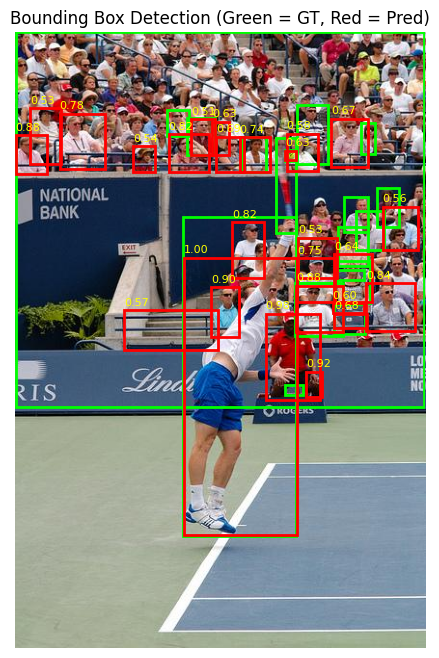

Precision: 0.1686665157251151
Recall: 0.7726212079925794


In [35]:
"""
iou_threshold è della precision singola calcolata
"""
precision, recall, map_results = evaluate_detector(model, data_loader_val, device="cuda", iou_threshold=0.5)
print("Precision:", precision)
print("Recall:", recall)